In [218]:
import torch
from torch import nn
from torch.autograd import Variable
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from sklearn.metrics import accuracy_score
%matplotlib inline

In [7]:
bsz = 10

train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=bsz, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
batch_size=bsz, shuffle=True)

    7     6     8     0


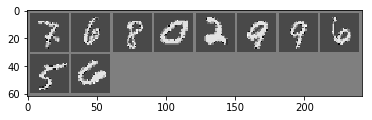

In [8]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
classes = list(range(10))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [244]:
EPS = 1e-10

class Leaf(nn.Module):
    def __init__(self, i_size, o_size, h_size=128):
        super(Leaf, self).__init__()
        self.i2h = nn.Linear(i_size, h_size)
        self.h2o = nn.Linear(h_size, o_size)
        self.soft = nn.LogSoftmax(1)
        self.relu = nn.ReLU()
        self.is_leaf = True

    def forward(self, features):
        out = self.i2h(features)
        out = self.relu(out)
        out = self.h2o(out)
        return self.soft(out)

    def accum_probs(self, features, path_prob):
        return [[path_prob, self.forward(features)]]

    def calc_regularization(self, features, path_prob):
        return 0

class Node(nn.Module):
    def __init__(self, i_size, o_size):
        super(Node, self).__init__()
        self.o_size = o_size
        self.i_size = i_size
        self.i2o = nn.Linear(i_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.is_leaf = False
    
    def build_tree(self, depth):
        if depth - 1 < 0:
            raise ValueError("Depth must be greater than zero.")
        if depth - 1 > 0:
            self.left = Node(self.i_size, self.o_size)
            self.right = Node(self.i_size, self.o_size)
            self.left.build_tree(depth - 1)
            self.right.build_tree(depth - 1)
        else:
            self.left = Leaf(self.i_size, self.o_size)
            self.right = Leaf(self.i_size, self.o_size)

    def forward(self, features):
        pr = self.prob_left(features)
        return pr*self.left(features) + (1 - pr)*self.right(features)

    def prob_left(self, features):
        return self.sigmoid(self.i2o(features))

    def accum_probs(self, features, path_prob):
        res = []
        p_l = self.sigmoid(self.i2o(features)).squeeze()
        res_l = self.left.accum_probs(features, p_l*path_prob)
        res_r = self.right.accum_probs(features, (1 - p_l)*path_prob)
        res.extend(res_l)
        res.extend(res_r)
        return res

    def calc_regularization(self, features, path_prob):
        p_l = self.prob_left(features).squeeze()
        alpha = (path_prob*p_l).sum()/(path_prob.sum())
        C_here = -0.5*torch.log(alpha + EPS) - 0.5*torch.log(1 - alpha + EPS)
        C = self.left.calc_regularization(features, p_l*path_prob) + \
                        self.right.calc_regularization(features, (1 - p_l)*path_prob)
        C = C + C_here
        return C
        

def tree_loss(path_probs, y_true, C, gamma):
    loss = 0
    criterion = nn.NLLLoss(reduce=False)
    for p, pred in path_probs:
        loss += (p*criterion(pred, y_true)).mean()
    return loss.mean() + gamma*C

def tree_logloss(path_probs, y_true):
    """
    Original loss from paper
    """
    loss = 0
    criterion = nn.NLLLoss()
    for p, pred in path_probs:
        loss -= (p.squeeze()*criterion(pred, y_true)).mean()
    return -torch.log(loss.mean())

def train(model, batches_train, batches_val, n_epoch=5, gamma=0.1,
          criterion=tree_loss, val_every=500, print_every=100):
    model.train()
    optimizer = optim.Adam(model.parameters())
    all_losses = np.zeros(print_every)
    plot_train = []
    plot_val = []
    for epoch in range(n_epoch):
        print('Epoch: {}'.format(epoch))
        for i, batch in enumerate(batches_train):
            optimizer.zero_grad()
            features, targets = batch
            features = Variable(features.view(-1, 28*28))
            targets = Variable(targets)
            prb = model.accum_probs(features, Variable(torch.Tensor([1]*targets.shape[0])))
            C = model.calc_regularization(features, Variable(torch.Tensor([1]*targets.shape[0])))
            loss = tree_loss(prb, targets, C, gamma=gamma)
            loss.backward()
            optimizer.step()
            plot_train += [loss.data[0]]
            all_losses[(i + 1)%print_every] = loss.data[0]
            if (i + 1) % print_every == 0:
                print(all_losses.max(), all_losses.mean())
            if (i + 1) % val_every == 0:
                plot_val += [validate(model, batches_val)]
    return plot_train, plot_val

def validate(model, batches_val):
    model.eval()
    y_pred = []
    y_true = []
    for batch in batches_val:
        features, targets = batch
        y_true += targets.tolist()
        y_pred += model(Variable(features.view(-1, 28*28))).topk(1)[1].squeeze().data.tolist()
    model.train()
    return accuracy_score(y_true, y_pred)

In [249]:
net = Node(28*28, 10)

In [250]:
net.build_tree(2)

In [251]:
validate(net, test_loader)

0.0883

In [252]:
training, testing = train(net, train_loader, test_loader, gamma=0, n_epoch=1)

Epoch: 0
2.3208134174346924 0.9850304496288299
1.124450922012329 0.4424265518411994
1.487255573272705 0.39970444157719615
1.1348315477371216 0.3702938113361597
1.466813564300537 0.3933159306133166
1.6960644721984863 0.3138192646577954
1.217405080795288 0.30514644775539634
1.1556371450424194 0.29529811756685376
1.191265344619751 0.22567772466689348
1.8193292617797852 0.27397711247205736
1.23622465133667 0.2687176687456667
1.2653847932815552 0.22984152415767312
1.8631157875061035 0.19994493345264344
1.286694884300232 0.2698298747185618
2.304396152496338 0.21439555362798274
1.6031297445297241 0.24639692983357236
1.064756155014038 0.22799287303350865
1.0995135307312012 0.2082734259031713
1.0551551580429077 0.20649951677769424
1.0215766429901123 0.25772748090326786
0.7689920663833618 0.17644611961208284
1.0986156463623047 0.18222827931400387
1.1006221771240234 0.16866874655243008
0.8370348215103149 0.17149998996872454
1.397258996963501 0.16925717217149214
1.1604899168014526 0.20883429812733

In [253]:
validate(net, test_loader)

0.9634

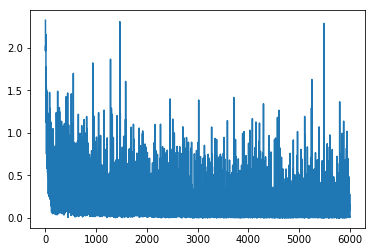

In [254]:
plt.plot(training)

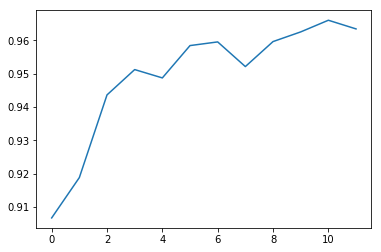

In [255]:
plt.plot(testing)

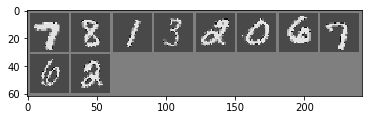

In [256]:
for data in test_loader:
    images, labels = data
    features = Variable(images.view(-1, 28*28))
    break
imshow(torchvision.utils.make_grid(images))

In [257]:
net(features).topk(1)[1]

Variable containing:
    7
    8
    1
    3
    2
    0
    6
    7
    6
    2
[torch.LongTensor of size 10x1]